# 基于出租车GPS的OD期望线绘制与底图添加（plot_map）
GIS文件(地理信息系统):  
1. 深圳行政区划
2. 深圳栅格

数据: 
1. 出租车GPS集计栅格OD  

In [35]:
#导入必要的包
import pandas as pd
import numpy as np

#绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas包
import geopandas

#shapely包
from shapely.geometry import Point,Polygon,shape

## 读取基础数据
### GIS数据

,centroid_x,centroid_y,qh,geometry
0,114.143157,22.577605,罗湖,"POLYGON ((114.10006 22.53431, 114.09969 22.535..."
1,114.041535,22.546180,福田,"POLYGON ((113.98578 22.51348, 113.98558 22.523..."
2,114.270206,22.596432,盐田,"POLYGON ((114.22772 22.54290, 114.22643 22.543..."
3,113.851387,22.679120,宝安,"MULTIPOLYGON (((113.81831 22.54676, 113.81816 ..."
4,113.926290,22.766157,光明,"POLYGON ((113.98587 22.80304, 113.98605 22.802..."


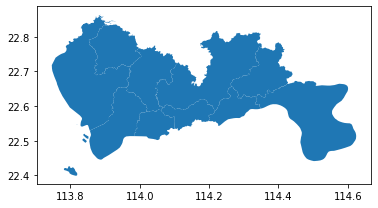

In [36]:
#行政区划数据
#读取shapefile文件
shp = '/home/liu/Documents/pygeo-tutorial/shapefile/sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp, encoding = 'utf-8')

#绘制看看什么样
xzqh.plot()
xzqh.head(5)

<AxesSubplot:>

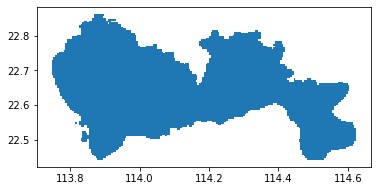

In [37]:
#栅格数据
#读取shapefile文件
shp = '/home/liu/Documents/pygeo-tutorial/shapefile/grid/grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')

#绘制
grid.plot()

### 栅格OD数据
这个数据是前面教程中用公式计算出来的OD

In [38]:
OD = pd.read_csv('/home/liu/Documents/pygeo-tutorial/data-sample/taxi_od_grid.csv')
OD.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum
0,63,17,65,16,298
1,75,21,74,19,275
2,63,18,65,16,235
3,76,21,74,19,173
4,65,17,63,18,172


## 栅格与小区,行政区的匹配
### 栅格中心点获取

In [39]:
#栅格所带的字段信息
grid.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,54,113.749504,22.688405,"POLYGON ((113.74707 22.68616, 113.74707 22.690..."
1,0,55,113.749504,22.692902,"POLYGON ((113.74707 22.69065, 113.74707 22.695..."
2,0,56,113.749504,22.697399,"POLYGON ((113.74707 22.69515, 113.74707 22.699..."
3,0,57,113.749504,22.701895,"POLYGON ((113.74707 22.69965, 113.74707 22.704..."
4,0,58,113.749504,22.706392,"POLYGON ((113.74707 22.70414, 113.74707 22.708..."


下一步我们定义一个geoDataFrame变量，命名为grid_point，存储的是栅格的中心点

<AxesSubplot:>

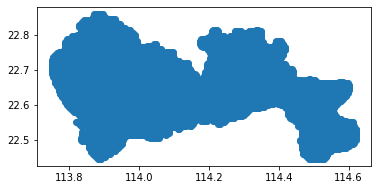

In [40]:
grid_point = grid.copy()
#我们相当于把geometry这一列的信息由polygon改成point
grid_point['geometry'] = grid.centroid

grid_point.plot()

In [41]:
grid_point.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,54,113.749504,22.688405,POINT (113.74950 22.68841)
1,0,55,113.749504,22.692902,POINT (113.74950 22.69290)
2,0,56,113.749504,22.697399,POINT (113.74950 22.69740)
3,0,57,113.749504,22.701895,POINT (113.74950 22.70190)
4,0,58,113.749504,22.706392,POINT (113.74950 22.70639)


### 空间连接sjoin
在对栅格和行政区划连接时,要用到geopandas的sjoin方法

In [42]:
#连接到行政区划
grid_point = geopandas.sjoin(grid_point, xzqh, how='inner', op='intersects')#类似于pandas.merge()
#'inner'表示内连接，且连接结果表中的矢量列来自左表
#'intersects'代表相交，即几何对象之间存在共有的边或内部点
grid_point.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry,index_right,centroid_x,centroid_y,qh
2,0,56,113.749504,22.697399,POINT (113.74950 22.69740),3,113.851387,22.67912,宝安
3,0,57,113.749504,22.701895,POINT (113.74950 22.70190),3,113.851387,22.67912,宝安
4,0,58,113.749504,22.706392,POINT (113.74950 22.70639),3,113.851387,22.67912,宝安
5,0,59,113.749504,22.710888,POINT (113.74950 22.71089),3,113.851387,22.67912,宝安
6,0,60,113.749504,22.715385,POINT (113.74950 22.71539),3,113.851387,22.67912,宝安


<AxesSubplot:>

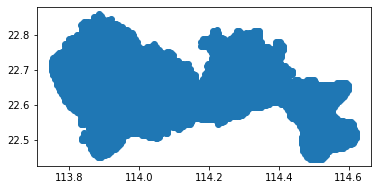

In [43]:
grid_point.plot()

In [44]:
#只取需要的列
grid_point = grid_point[['LONCOL','LATCOL','qh','centroid_x','centroid_y']]

### 把OD表的起点终点和grid_point表连接
这里用df.merge,把OD和grid_point表连接起来

In [45]:
grid_point.columns = ['SLONCOL','SLATCOL','Sqh','S_x','S_y']
OD = pd.merge(OD,grid_point, on = ['SLONCOL','SLATCOL'])
grid_point.columns = ['ELONCOL','ELATCOL','Eqh','E_x','E_y']
OD = pd.merge(OD,grid_point,on = ['ELONCOL','ELATCOL'])
OD.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,Sqh,S_x,S_y,Eqh,E_x,E_y
0,63,17,65,16,298,福田,114.041535,22.546180,福田,114.041535,22.54618
1,75,21,65,16,139,罗湖,114.143157,22.577605,福田,114.041535,22.54618
2,63,18,65,16,235,福田,114.041535,22.546180,福田,114.041535,22.54618
3,76,21,65,16,89,罗湖,114.143157,22.577605,福田,114.041535,22.54618
4,65,17,65,16,64,福田,114.041535,22.546180,福田,114.041535,22.54618


### 集计行政区划的OD

In [46]:
#集记行政区划的OD
OD = OD.groupby(['Sqh','S_x','S_y','Eqh','E_x','E_y'])['VehicleNum'].sum().reset_index()
OD.head(5)

,Sqh,S_x,S_y,Eqh,E_x,E_y,VehicleNum
0,光明,113.92629,22.766157,光明,113.926290,22.766157,141
1,光明,113.92629,22.766157,南山,113.930714,22.544103,8
2,光明,113.92629,22.766157,宝安,113.851387,22.679120,119
3,光明,113.92629,22.766157,福田,114.041535,22.546180,3
4,光明,113.92629,22.766157,罗湖,114.143157,22.577605,2


In [47]:
OD = OD[-(OD['Sqh']==OD['Eqh'])]

## OD的绘制

In [49]:
OD = OD.sort_values(by = 'VehicleNum')
OD.head(5)

,Sqh,S_x,S_y,Eqh,E_x,E_y,VehicleNum
30,大鹏,114.502205,22.571337,龙岗,114.206790,22.695694,1
26,大鹏,114.502205,22.571337,宝安,113.851387,22.679120,1
24,大鹏,114.502205,22.571337,坪山,114.356936,22.691020,1
21,坪山,114.356936,22.691020,罗湖,114.143157,22.577605,1
19,坪山,114.356936,22.691020,宝安,113.851387,22.679120,1


In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt

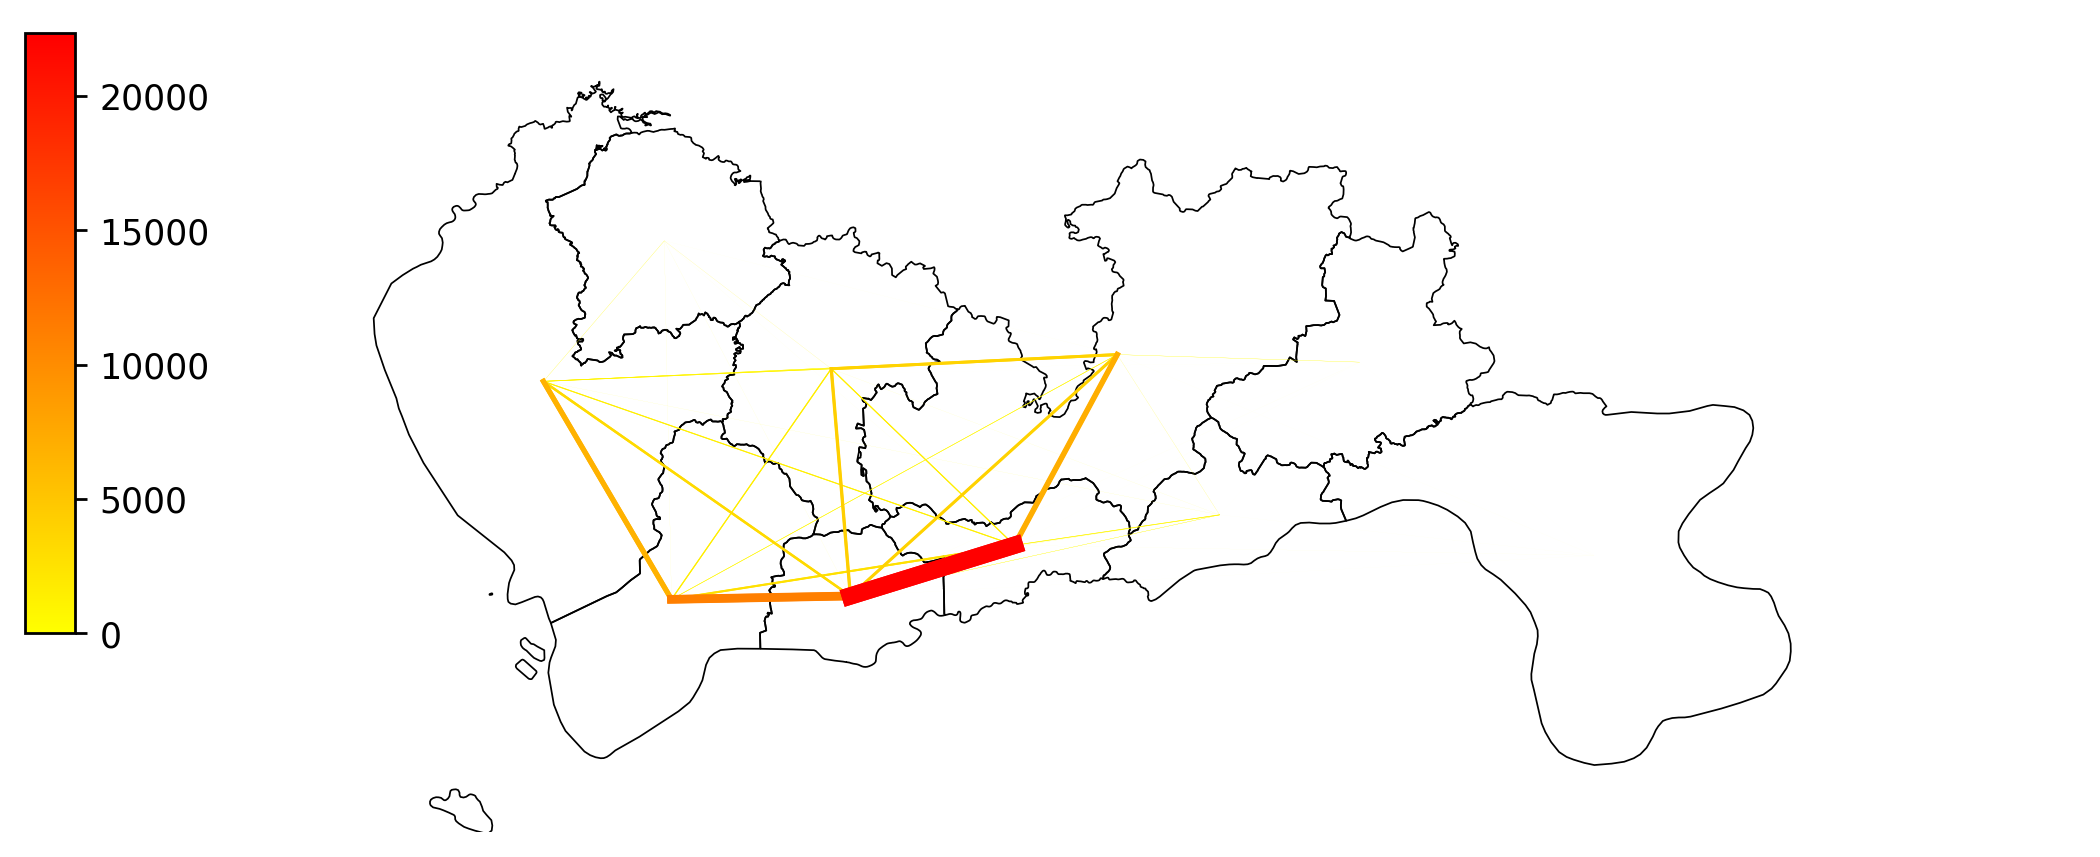

In [55]:
fig = plt.figure(1,(10,8),dpi = 250)
ax = plt.subplot(111)
plt.sca(ax)
#绘制行政区划
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths = 0.5)
#设置colormap的数据
import matplotlib 
vmax = OD['VehicleNum'].max()
#设定一个标准化的工具,设定OD的colormap最大最小值,他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#设定colormap的颜色
cmapname = 'autumn_r'
#设定一个标准化的工具,cmap(a)会返回颜色,其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
for i in range(len(OD)):
    #设定第i条线的color和linewidth
    color_i = cmap(norm(OD['VehicleNum'].iloc[i]))
    linewidth_i = norm(OD['VehicleNum'].iloc[i])*5
    
    #绘制
    plt.plot([OD['S_x'].iloc[i],OD['E_x'].iloc[i]],[OD['S_y'].iloc[i],OD['E_y'].iloc[i]],color = color_i,linewidth = linewidth_i)
    
#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
#所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
#然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

###################################################################################

plt.show()

## 用plot_map包绘制底图
只需要用以下代码：  
  
`plot_map(plt,bounds,zoom = 9,style = 1)`  
可以通过更改函数plot map中的“style”和“styleid”来更改地图样式  
bounds——设置绘图边界`[lon1，lat1，lon2，lat2]`（wgs1984）  
zoom——地图的缩放级别  
style——从1到7表示不同的地图样式，1-6表示openstreetmap，7表示mapbox，样式3和4不需要token  
styleid——如果style设置为7（来自mapbox），则可以在此处更改styleid，用“深色”或“浅色”或您自己的样式  

imgsavepath do not exist, your tile map will not save


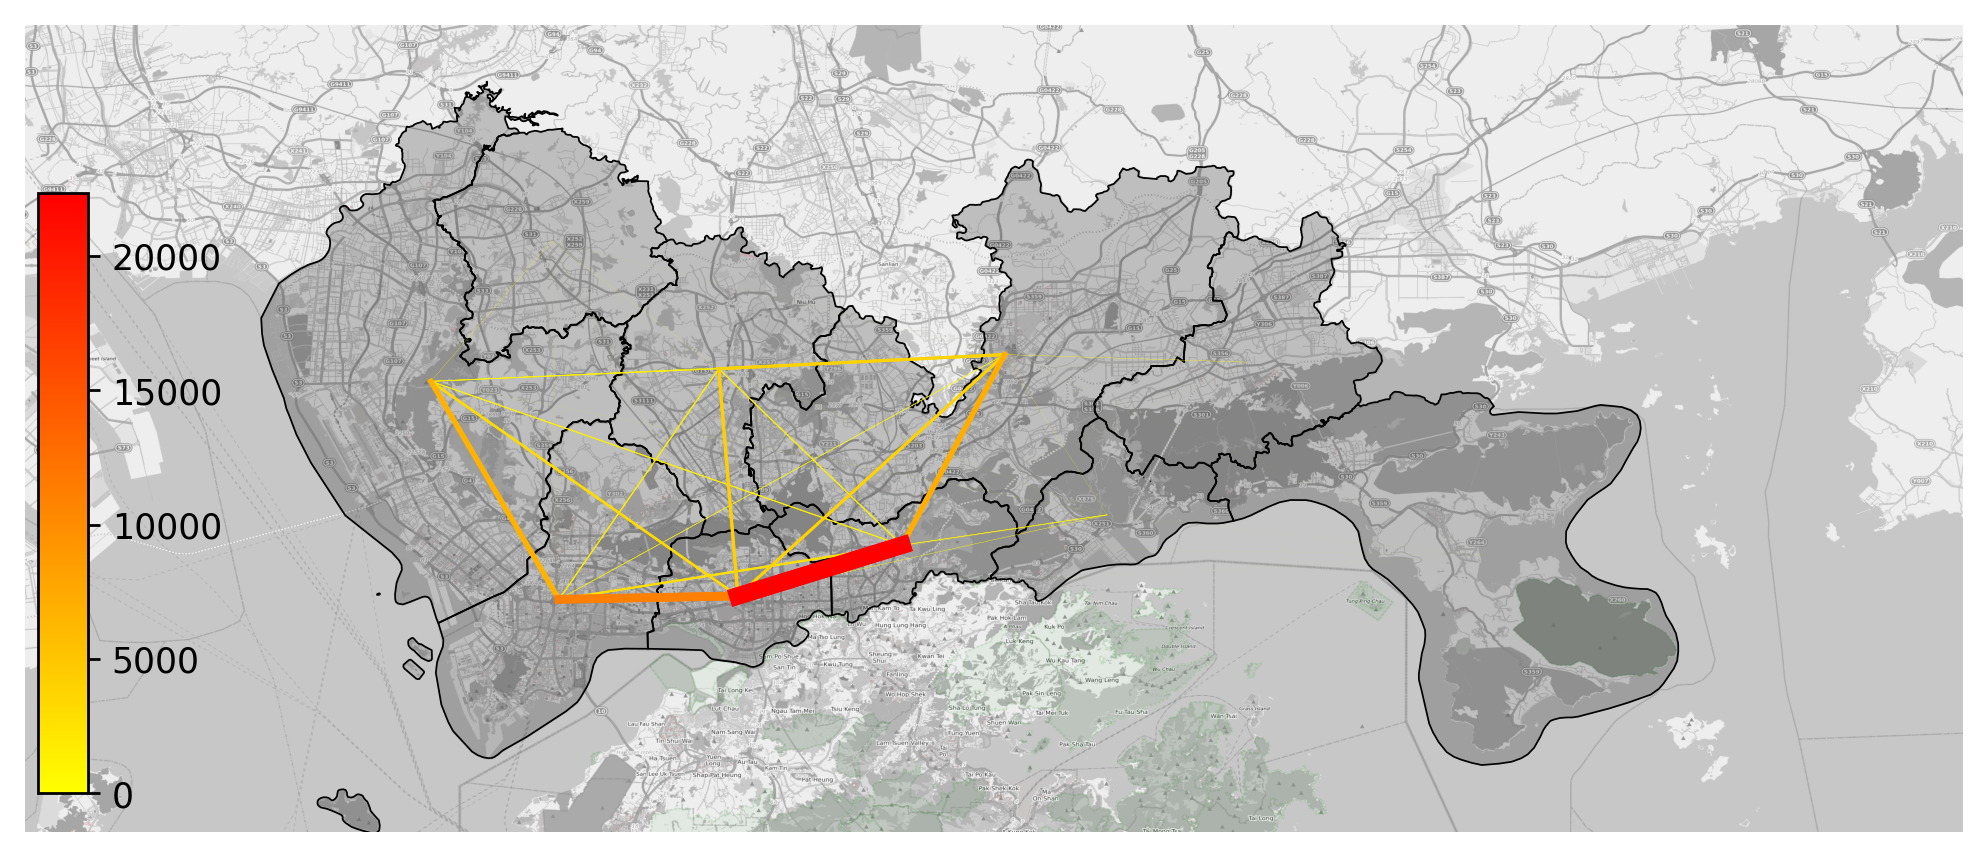

In [60]:
import plot_map

fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

bounds = [113.6,22.4,114.8,22.9]
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#绘制行政区划
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)

#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
for i in range(len(OD)):
    color_i=cmap(norm(OD['VehicleNum'].iloc[i]))
    linewidth_i=norm(OD['VehicleNum'].iloc[i])*5
    plt.plot([OD['S_x'].iloc[i],OD['E_x'].iloc[i]],[OD['S_y'].iloc[i],OD['E_y'].iloc[i]],color=color_i,linewidth=linewidth_i)


    
#不显示坐标轴
plt.axis('off')    

#添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)


plt.show()